## Interface and Validation

After training the network we can use it for making predictions. This is also known as inference. However, neural networks have a tendency to perform too $well$ on the training data and aren't able to generalize to the data that hasn't been seen before. This phenomenon is called as over fitting and it impairs inference performance. To test for overfitting, we measure the performance data not in the training set called as the <b>validation</b> set. We avoid overfitting through regularization such as dropout while monitoring validation performance during training. 

Following is the process to do that. 

As usual, first we start by importing the data.

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,),(0.5,))])

# Download and load the training data 
trainset = datasets.FashionMNIST('~/pytorch/F_MNIST_data/', download = True, train = True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size = 64, shuffle = True)

# Download and load the test data
testset = datasets.FashionMNIST('~/pytorch/F_MNIST_data/', download = True, train = False, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

Creating the neural network model

In [2]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
        
    def forward(self,x):
        # flattening the input tensor
        
        x = x.view(x.shape[0],-1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim = 1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are precision and recall and top 5 error rate. 

In [3]:
#Forward pass through the network

model = Classifier()
images,labels = next(iter(testloader))

# Get the class probabilities
ps = torch.exp(model(images))

# Make sure the shape is appropriate, we should get 10 proabilities for 64 eaxmples

print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using ps.topk method. This returns the $k$ highest values. Since we just want the most likely class, we can use ps.topk(1). This returns a tuple of top-$k$ values and top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [4]:
top_p, top_class = ps.topk(1, dim = 1)
# Look at the most likely classes for the firt 10 examples
print(top_class[:10,:])

tensor([[4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [5],
        [4],
        [4],
        [5]])


Now we can check if the predicted classes match the labels. This is simple to do by equating top_class and labels, but we have to be careful of the shapes. Here top_class is a 2D tensor with shape (64,1) while labels is 1D with shape (64). To get the equality to work out the way we want, top_class and labels must have the same shape.

In [5]:
equals = top_class == labels.view(*top_class.shape)

Now we need to calculate the percentage of correct predictions. equals has binary values either 0 or 1. This means if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. 

equals is a tensor with boolean values. To take the mean of the values, we first need to converty it to a float tensor

In [6]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 14.0625%


Since this network is not trained, it is making random guesses and hence the accuracy is very low. 

Now, lets ttrain the network by including a validation pass so we can measure how well the network is performing on the test set. Since we are not updating our parameters in the validation passs, we can speed up the process by turning off gradients using torch.no_grad():

In [7]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

epoch = 30
steps = 0

train_losses, test_losses = [],[]

for e in range(epoch):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        
        # Turn off gradients for validation, saves memory and computations
        
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim =1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        
        print("Epoch: {}/{}..".format(e+1,epoch),
             "Training Loss: {:.3f}..".format(running_loss/len(trainloader)),
             "Test Loss: {:.3f}..".format(test_loss/len(testloader)),
             "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30.. Training Loss: 0.517.. Test Loss: 0.465.. Test Accuracy: 0.828
Epoch: 2/30.. Training Loss: 0.390.. Test Loss: 0.415.. Test Accuracy: 0.855
Epoch: 3/30.. Training Loss: 0.357.. Test Loss: 0.385.. Test Accuracy: 0.861
Epoch: 4/30.. Training Loss: 0.330.. Test Loss: 0.391.. Test Accuracy: 0.859
Epoch: 5/30.. Training Loss: 0.312.. Test Loss: 0.402.. Test Accuracy: 0.859
Epoch: 6/30.. Training Loss: 0.302.. Test Loss: 0.370.. Test Accuracy: 0.869
Epoch: 7/30.. Training Loss: 0.291.. Test Loss: 0.363.. Test Accuracy: 0.867
Epoch: 8/30.. Training Loss: 0.281.. Test Loss: 0.358.. Test Accuracy: 0.875
Epoch: 9/30.. Training Loss: 0.270.. Test Loss: 0.372.. Test Accuracy: 0.870
Epoch: 10/30.. Training Loss: 0.263.. Test Loss: 0.383.. Test Accuracy: 0.870
Epoch: 11/30.. Training Loss: 0.254.. Test Loss: 0.357.. Test Accuracy: 0.879
Epoch: 12/30.. Training Loss: 0.249.. Test Loss: 0.381.. Test Accuracy: 0.870
Epoch: 13/30.. Training Loss: 0.244.. Test Loss: 0.378.. Test Accuracy: 0

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

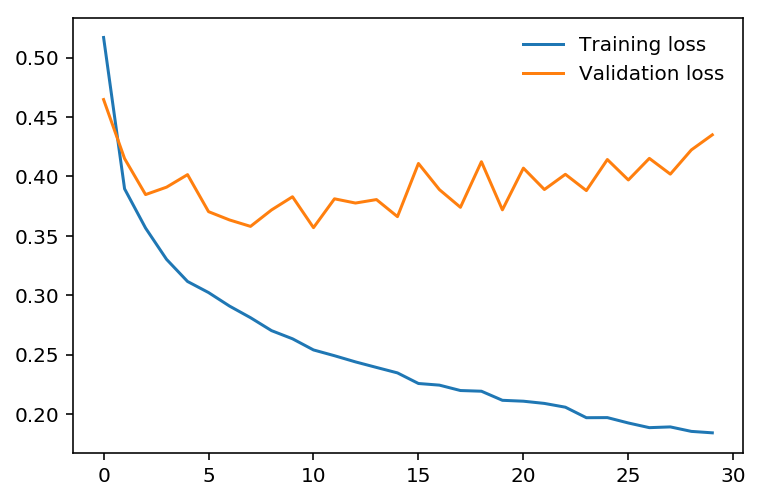

In [9]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.legend(frameon=False)

### Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

The network learns the training data better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate aim of a deep learning model is to make predictions on te new data, so we should strive to get the lowest validation loss as possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10. This strategy is called $early stopping$. 

Another common practice to reduce overfitting is $dropout$, where we randomly drop input units. This forces the network to share information between weights, increasing its ability to generalize to new data. Adding dropuout in PyTorch s straightforward using the nn.Droupout module.

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
        
        # Droupout module with 0.2 drop probability
        self.droupout = nn.Dropout(p=0.2)
        
    def forward(self,x):
        # make sure input tensor is flattened
        
        x = x.view(x.shape[0],-1)
        
        # Now with dropout 
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # Output so no drop out here
        
        x = F.log_softmax(self.fc4(x), dim =1)
        
        return x

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So we need to turn off dropout durung validation, testing and whereever we are using the network to make predictions. To do this you use model.eval(). This sets the model to evaluation mode where the dropout probability is zero. You can turn dropoutback on by setting the model to train model with model.train(). In general, the pattern for validation loop will look like thhis, where you tunr off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

In [11]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
        
        # Dropout module with 0.2 drop probability 
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,x):
        
        #Make sure the input tensor is flattened 
        x = x.view(x.shape[0],-1)
        
        # Now with dropout
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # Output so no dropout here
        
        x = F.log_softmax(self.fc4(x), dim =1)
        
        return x

In [17]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

epochs = 30
steps = 0

train_losses,test_losses =[],[]

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        #Turn off the gradients for validation, saves memory and computations
        
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1,dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}..".format(e+1,epochs),
             "Training Loss: {:.3f}..".format(train_losses[-1]),
             "Test Loss: {:.3f}..".format(test_losses[-1]),
             "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))               

Epoch: 1/30.. Training Loss: 0.610.. Test Loss: 0.484.. Test Accuracy: 0.822
Epoch: 2/30.. Training Loss: 0.483.. Test Loss: 0.438.. Test Accuracy: 0.846
Epoch: 3/30.. Training Loss: 0.453.. Test Loss: 0.437.. Test Accuracy: 0.842
Epoch: 4/30.. Training Loss: 0.434.. Test Loss: 0.402.. Test Accuracy: 0.856
Epoch: 5/30.. Training Loss: 0.429.. Test Loss: 0.401.. Test Accuracy: 0.857
Epoch: 6/30.. Training Loss: 0.418.. Test Loss: 0.388.. Test Accuracy: 0.862
Epoch: 7/30.. Training Loss: 0.402.. Test Loss: 0.405.. Test Accuracy: 0.861
Epoch: 8/30.. Training Loss: 0.402.. Test Loss: 0.412.. Test Accuracy: 0.855
Epoch: 9/30.. Training Loss: 0.393.. Test Loss: 0.389.. Test Accuracy: 0.860
Epoch: 10/30.. Training Loss: 0.390.. Test Loss: 0.380.. Test Accuracy: 0.865
Epoch: 11/30.. Training Loss: 0.390.. Test Loss: 0.390.. Test Accuracy: 0.864
Epoch: 12/30.. Training Loss: 0.380.. Test Loss: 0.377.. Test Accuracy: 0.869
Epoch: 13/30.. Training Loss: 0.381.. Test Loss: 0.381.. Test Accuracy: 0

In [18]:
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'

import matplotlib.pyplot as plt

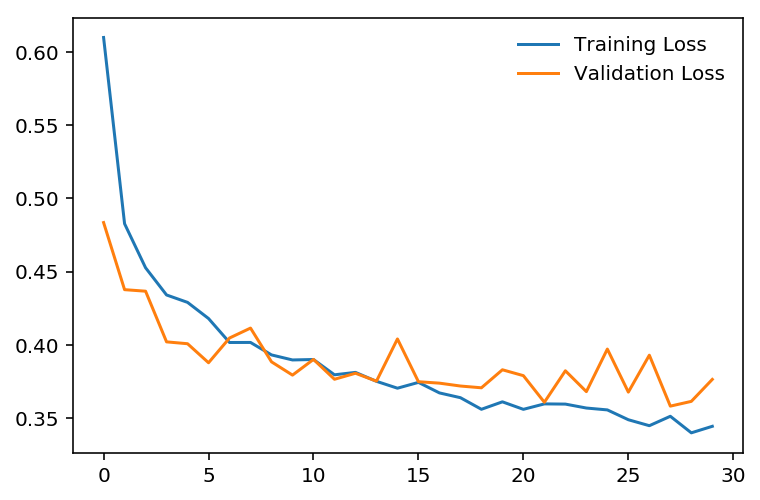

In [19]:
plt.plot(train_losses, label ='Training Loss')
plt.plot(test_losses, label = 'Validation Loss')
plt.legend(frameon = False)

### Inference

Now that the model is well trained, we can use it for inference. We've done this before, but now we have to set the model in inferece mode model.eval(). Gradients also needed to be turned of for this

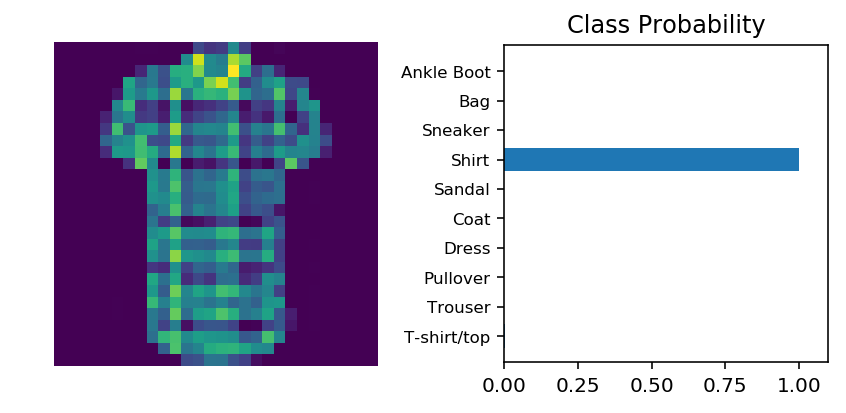

In [29]:
# Import Helper Module
import helper

# Testing the network

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]

# Convert 2D images to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)
    
ps = torch.exp(output)

# Plot the image and probailities
helper.view_classify(img.view(1,28,28), ps, version = 'Fashion')